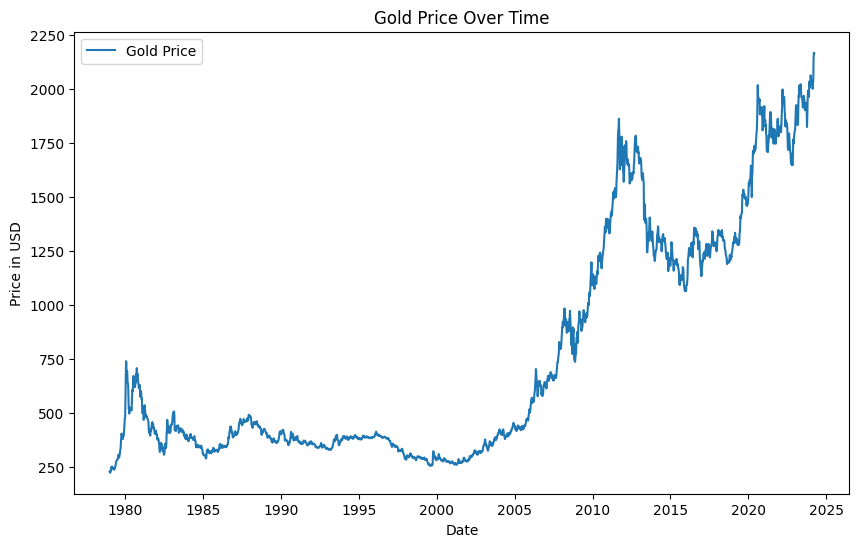

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

price_path = ".\\data\\gold\\Prices.csv"
goldPrice = pd.read_csv(price_path)

goldPrice = goldPrice[['Date', 'USD']]
goldPrice['Date'] = pd.to_datetime(goldPrice['Date'])
goldPrice.set_index('Date', inplace=True)

goldPrice['USD'] = pd.to_numeric(goldPrice['USD'].replace(',', '', regex=True), errors='coerce')

goldPrice_weekly = goldPrice['USD'].resample('W').mean()
goldPrice_weekly

plt.figure(figsize=(10,6))
plt.plot(goldPrice_weekly.index, goldPrice_weekly, label='Gold Price')

# k_wave_starts = ['1930', '1980', '2030']
# for year in k_wave_starts:
#     plt.axvline(pd.to_datetime(year), color='r', linestyle='--')

plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

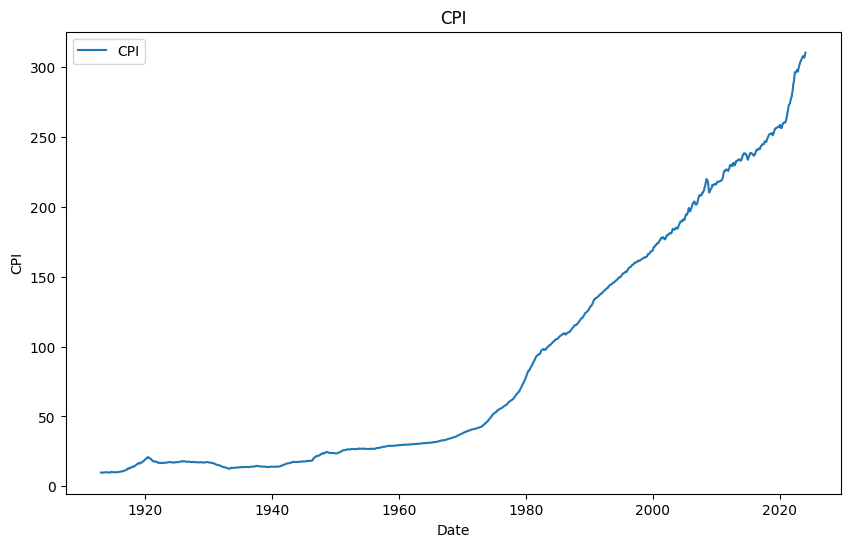

In [38]:
CPI_path = ".\\data\\macro\\CPI.csv"
CPI = pd.read_csv(CPI_path)
CPI['Date'] = pd.to_datetime(CPI['Date'])
CPI.set_index('Date', inplace=True)
# CPI
plt.figure(figsize=(10,6))
plt.plot(CPI.index, CPI, label='CPI')
plt.title('CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()